# グリッドサーチ

Prophetによる面積予測プログラムを開始します: root_area_data_mm2_plant6-.xlsx
  データ数 : 136 件
  最大値   : 105.83 面積 (mm^2)
  学習期間 : 2025-12-06 18:23:31 〜 2025-12-10 10:21:48
  検証期間 : 2025-12-10 11:22:29 〜 2025-12-12 10:54:15

Grid Search Start (135 combinations)...


16:50:20 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] done processing
16:50:21 - cmdstanpy - INFO - Chain [1] start processing
16:50:21 - cmdstanpy - INFO - Chain [1] done processing
16:50:21 - cmdstanpy - INFO - Chain [1] start processing
16:50:22 - cmdstanpy - INFO - Chain [1] done processing
16:50:22 - cmdstanpy - INFO - Chain [1] start processing
16:50:22 - cmdstanpy - INFO - Chain [1] done processing
16:50:23 - cmdstanpy - INFO - Chain [1] start processing
16:50:23 - cmdstanpy - INFO - Chain [1] done processing
16:50:23 - cmdstanpy - INFO - Chain [1] start processing
16:50:24 - cmdstanpy - INFO - Chain [1] done processing
16:50:24 - cmdstanpy - INFO - Chain [1] start processing
16:50:24 - cmdstanpy - INFO - Chain [1] done processing
16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:25 - cmdstanpy - INFO - Chain [1] done processing
16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:26 - cmdstanpy - INFO - Chain [1]

Grid Search Complete.
  Best MSE    : 1.8250
  Best Params : {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'daily_fourier_order': 1, 'cap_multiplier': 1.05, 'final_cap_value': 111.12174605402504}

Building Final Model...


16:52:58 - cmdstanpy - INFO - Chain [1] done processing



[Validation Results]
  RMSE : 1.35
  MAPE : 1.29%

Saved CSV: forecast_results_comparison_area_mm2-1.csv
Saved Image: forecast_plot_comparison_area_mm2-1.png


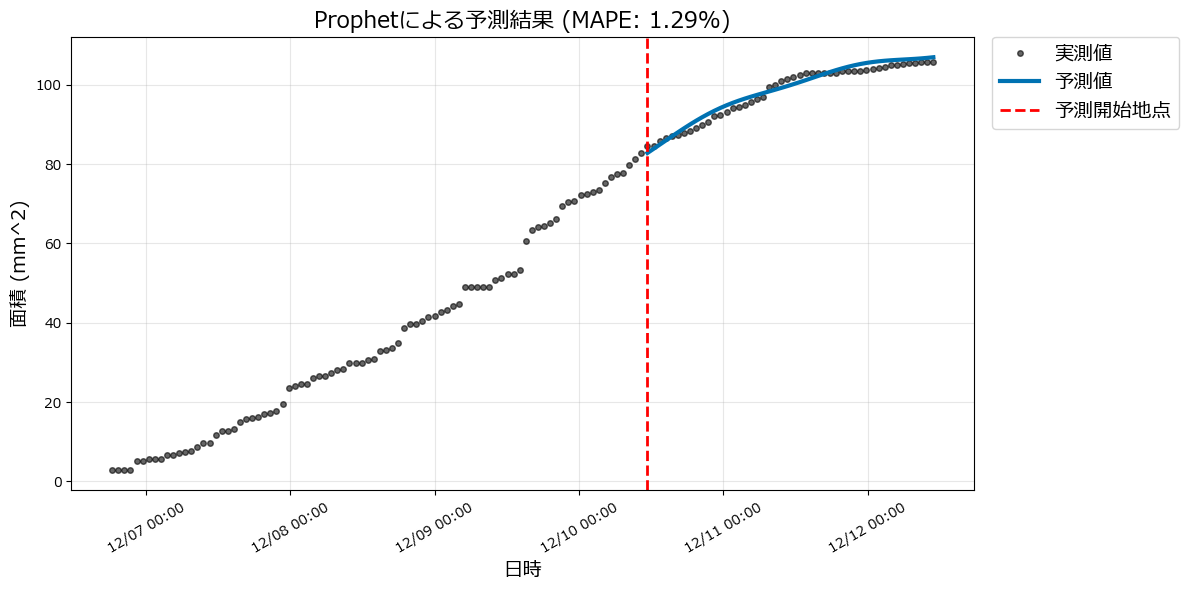

In [1]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import os
import sys
import itertools

# 日本語フォントの設定
try:
    import japanize_matplotlib
except ImportError:
    from matplotlib import rcParams
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Meiryo', 'Yu Gothic', 'Hiragino Maru Gothic Pro']

# ==========================================
# 設定パラメータ
# ==========================================
INPUT_FILE_NAME = 'root_area_data_mm2_plant6-.xlsx'   # 入力ファイル (mm2変換済み)
RESULT_CSV_NAME = 'forecast_results_comparison_area_mm2-1.csv'
RESULT_IMG_NAME = 'forecast_plot_comparison_area_mm2-1.png'

VALIDATION_DAYS = 2        # 検証期間 (直近48時間をテストデータとする)

def extract_date(x):
    """ファイル名から日時情報を抽出する"""
    match = re.search(r'(\d{8})_(\d{6})', str(x))
    if match:
        return pd.to_datetime(f"{match.group(1)} {match.group(2)}", format='%Y%m%d %H%M%S')
    return None

def main():
    print(f"Prophetによる面積予測プログラムを開始します: {INPUT_FILE_NAME}")

    # 1. データ読み込み
    if not os.path.exists(INPUT_FILE_NAME):
        print(f"Error: ファイル '{INPUT_FILE_NAME}' が見つかりません。")
        sys.exit()

    try:
        df = pd.read_excel(INPUT_FILE_NAME, engine='openpyxl')
    except Exception as e:
        print(f"Error: 読み込み失敗 ({e})")
        sys.exit()

    # カラム名の正規化
    if 'filename' not in df.columns:
        df.rename(columns={df.columns[0]: 'filename'}, inplace=True)
    
    df['ds'] = df['filename'].apply(extract_date)

    # ターゲット変数の設定 (面積: mm^2)
    unit_label = "面積 (mm^2)"
    if 'area_mm2' in df.columns:
        df['y'] = df['area_mm2']
    elif 'area_cm2' in df.columns:
        print("Info: 'area_cm2' を代用します。")
        df['y'] = df['area_cm2']
        unit_label = "面積 (cm^2)"
    elif 'area_pixels' in df.columns:
        print("Info: 'area_pixels' を代用します。")
        df['y'] = df['area_pixels']
        unit_label = "面積 (pixels)"
    else:
        print("Error: 面積データ列が見つかりません。")
        sys.exit()

    # データクリーニング
    df_clean = df[['ds', 'y']].dropna().sort_values('ds').reset_index(drop=True)
    current_max_y = df_clean['y'].max()

    print(f"  データ数 : {len(df_clean)} 件")
    print(f"  最大値   : {current_max_y:.2f} {unit_label}")

    # 2. 学習データと検証データの分割
    validation_len = VALIDATION_DAYS * 24
    if len(df_clean) <= validation_len:
        validation_len = int(len(df_clean) * 0.2)

    train_size = len(df_clean) - validation_len
    df_train_base = df_clean.iloc[:train_size].copy()
    df_valid_base = df_clean.iloc[train_size:].copy()

    print(f"  学習期間 : {df_train_base['ds'].min()} 〜 {df_train_base['ds'].max()}")
    print(f"  検証期間 : {df_valid_base['ds'].min()} 〜 {df_valid_base['ds'].max()}")

    # 3. グリッドサーチによるハイパーパラメータ探索
    # ロジスティック成長モデルの適合度を高めるため、パラメータを網羅的に探索する
    param_grid = {
        'changepoint_prior_scale': [0.05, 0.1, 0.3],
        'seasonality_prior_scale': [0.01, 0.1, 1.0],
        'daily_fourier_order': [1, 2, 3],
        'cap_multiplier': [1.05, 1.1, 1.15, 1.2, 1.3]
    }

    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    print(f"\nGrid Search Start ({len(all_params)} combinations)...")

    best_mse = float('inf')
    best_params = {}

    for params in all_params:
        # 上限値(cap)の設定: 現在の最大値に対する倍率で探索
        current_cap = current_max_y * params['cap_multiplier']
        
        df_train_t = df_train_base.copy()
        df_train_t['cap'] = current_cap
        
        m = Prophet(
            growth='logistic',
            daily_seasonality=False,
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale']
        )
        m.add_seasonality(name='daily', period=1, fourier_order=params['daily_fourier_order'])

        try:
            m.fit(df_train_t)
            
            df_valid_t = df_valid_base.copy()
            df_valid_t['cap'] = current_cap
            future = df_valid_t[['ds', 'cap']]
            forecast = m.predict(future)
            
            mse = mean_squared_error(df_valid_t['y'], forecast['yhat'])
            
            if mse < best_mse:
                best_mse = mse
                best_params = params.copy()
                best_params['final_cap_value'] = current_cap 
                
        except Exception:
            continue

    print(f"Grid Search Complete.")
    print(f"  Best MSE    : {best_mse:.4f}")
    print(f"  Best Params : {best_params}")

    # 4. 最適モデルによる最終予測
    print("\nBuilding Final Model...")
    best_cap_value = best_params['final_cap_value']

    df_final_train = df_train_base.copy()
    df_final_train['cap'] = best_cap_value

    m_final = Prophet(
        growth='logistic',
        daily_seasonality=False,
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale']
    )
    m_final.add_seasonality(name='daily', period=1, fourier_order=best_params['daily_fourier_order'])

    m_final.fit(df_final_train)

    # 全期間に対する予測を実行
    future = df_clean[['ds']].copy()
    future['cap'] = best_cap_value
    forecast = m_final.predict(future)

    # 5. 評価と結果の出力
    compare_df = pd.merge(df_valid_base[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')
    
    rmse = 0
    mape = 0
    if not compare_df.empty:
        rmse = np.sqrt(mean_squared_error(compare_df['y'], compare_df['yhat']))
        mape = mean_absolute_percentage_error(compare_df['y'], compare_df['yhat'])
        print(f"\n[Validation Results]")
        print(f"  RMSE : {rmse:.2f}")
        print(f"  MAPE : {mape:.2%}")

    # CSV保存
    output_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].copy()
    output_df.to_csv(RESULT_CSV_NAME, index=False, encoding='utf-8_sig')
    print(f"\nSaved CSV: {RESULT_CSV_NAME}")

    # グラフ描画と保存
    fig, ax = plt.subplots(figsize=(12, 6))

    # 実測値プロット
    ax.plot(df_clean['ds'], df_clean['y'], 'k.', label='実測値', alpha=0.6, markersize=8)

    # 予測値プロット (検証期間のみ)
    valid_start = df_valid_base['ds'].min()
    forecast_valid = forecast[forecast['ds'] >= valid_start]
    ax.plot(forecast_valid['ds'], forecast_valid['yhat'], label='予測値', color='#0072B2', linewidth=3)

    # 予測開始ライン
    ax.axvline(x=valid_start, color='red', linestyle='--', label='予測開始地点', linewidth=2)

    # グラフ装飾
    ax.set_title(f'Prophetによる予測結果 (MAPE: {mape:.2%})', fontsize=16)
    ax.set_xlabel('日時', fontsize=14)
    ax.set_ylabel(unit_label, fontsize=14)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    plt.xticks(rotation=30)
    ax.grid(True, alpha=0.3)

    # 凡例
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14)

    plt.tight_layout()
    plt.savefig(RESULT_IMG_NAME, bbox_inches='tight')
    print(f"Saved Image: {RESULT_IMG_NAME}")
    plt.show()

if __name__ == "__main__":
    main()

#　LSTM

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional
import re
import os
import sys

# 日本語フォントの設定
try:
    import japanize_matplotlib
except ImportError:
    from matplotlib import rcParams
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Meiryo', 'Yu Gothic', 'Hiragino Maru Gothic Pro']

# ==========================================
# 設定パラメータ
# ==========================================
# 1. 入力ファイル (mm2換算済みデータ)
INPUT_FILE = 'root_area_data_mm2_plant6-.xlsx'

# 2. 保存するファイル名 (自由に指定してください)
OUTPUT_CSV_FILE = 'lstm_prediction_result6-1.csv'   # 数値結果
OUTPUT_IMG_FILE = 'lstm_prediction_plot6-1.png'     # グラフ画像

# 3. ハイパーパラメータ
VALIDATION_DAYS = 2       # 検証期間 (日数)
LOOKBACK = 72             # 過去72時間分を入力とする
EPOCHS = 100              # 学習エポック数
BATCH_SIZE = 16           # バッチサイズ
# ==========================================

def extract_date(filename):
    """ファイル名から日時情報を抽出する"""
    match = re.search(r'(\d{8})_(\d{6})', str(filename))
    if match:
        return pd.to_datetime(f"{match.group(1)} {match.group(2)}", format='%Y%m%d %H%M%S')
    return None

def load_and_clean_data(filepath):
    """ファイルを読み込み、前処理を行ったDataFrameと単位ラベルを返す"""
    if not os.path.exists(filepath):
        print(f"Error: File not found -> {filepath}")
        return None, None

    try:
        # 拡張子に応じた読み込み
        if filepath.endswith('.xlsx'):
            df = pd.read_excel(filepath, engine='openpyxl')
        else:
            try:
                df = pd.read_csv(filepath, encoding='utf-8')
            except UnicodeDecodeError:
                df = pd.read_csv(filepath, encoding='cp932')
        
        # カラム名正規化
        if 'filename' not in df.columns:
            df.rename(columns={df.columns[0]: 'filename'}, inplace=True)

        # 日時抽出
        df['ds'] = df['filename'].apply(extract_date)

        # ターゲット変数(y)の選定
        unit_label = "面積 (pixels)"
        if 'area_mm2' in df.columns:
            df['y'] = df['area_mm2']
            unit_label = "面積 (mm^2)"
        elif 'area_cm2' in df.columns:
            df['y'] = df['area_cm2']
            unit_label = "面積 (cm^2)"
        elif 'area_pixels' in df.columns:
            df['y'] = df['area_pixels']
        elif len(df.columns) >= 2:
            df['y'] = df.iloc[:, 1]
        
        # 欠損値除去とソート
        df_clean = df[['ds', 'y']].dropna().sort_values('ds').reset_index(drop=True)
        return df_clean, unit_label

    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None, None

def create_dataset(dataset, lookback):
    """時系列データからLSTM用の入力(X)と正解(y)を作成"""
    X, y = [], []
    for i in range(len(dataset) - lookback):
        X.append(dataset[i:(i + lookback), 0])
        y.append(dataset[i + lookback, 0])
    return np.array(X), np.array(y)

def build_model(input_shape):
    """双方向LSTMモデルの構築"""
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True, input_shape=input_shape)),
        Bidirectional(LSTM(50)),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def main():
    print("LSTMによる成長予測プログラムを開始します...")
    
    # 1. データ読み込み
    df, unit_label = load_and_clean_data(INPUT_FILE)
    if df is None or len(df) <= LOOKBACK:
        print("Error: データ不足または読み込み失敗")
        return

    print(f"  Loaded: {INPUT_FILE} ({len(df)} records)")

    # 2. スケーリング
    scaler = MinMaxScaler(feature_range=(0, 1))
    raw_data = df['y'].values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(raw_data)

    # 3. 学習データ作成 (検証期間を除外)
    validation_len = VALIDATION_DAYS * 24
    train_size = len(scaled_data) - validation_len
    
    train_data = scaled_data[:train_size]
    X_train, y_train = create_dataset(train_data, LOOKBACK)
    
    # LSTM入力形状へ変換 [samples, time_steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    print(f"  Training Samples: {X_train.shape[0]}")

    # 4. モデル学習
    print("\nTraining LSTM Model...")
    model = build_model((LOOKBACK, 1))
    model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)

    # 5. 予測実行 (検証期間を含むデータを使用)
    test_data_source = scaled_data[train_size - LOOKBACK:]
    
    if len(test_data_source) > LOOKBACK:
        X_test, y_test = create_dataset(test_data_source, LOOKBACK)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        
        # 推論
        predictions = model.predict(X_test, verbose=0)
        
        # スケール逆変換
        predictions_actual = scaler.inverse_transform(predictions)
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
        
        # 精度評価
        rmse = np.sqrt(np.mean(((predictions_actual - y_test_actual) ** 2)))
        mape = np.mean(np.abs((y_test_actual - predictions_actual) / y_test_actual)) * 100
        
        print(f"\n[Validation Results]")
        print(f"  RMSE : {rmse:.2f}")
        print(f"  MAPE : {mape:.2f}%")
        
        # 6. 結果保存 (CSV)
        test_start_idx = len(df) - len(predictions_actual)
        test_dates = df['ds'][test_start_idx:]
        
        res_df = pd.DataFrame({
            'ds': test_dates.values,
            'y_actual': y_test_actual.flatten(),
            'y_pred': predictions_actual.flatten()
        })
        res_df.to_csv(OUTPUT_CSV_FILE, index=False)
        print(f"  Saved CSV: {OUTPUT_CSV_FILE}")

        # 7. グラフ描画と保存
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # 実測値
        ax.plot(df['ds'], df['y'], 'k.', label='実測値', alpha=0.6, markersize=8)
        # 予測値
        ax.plot(test_dates, predictions_actual, label='予測値', color='#0072B2', linewidth=3)
        # 境界線
        ax.axvline(x=df['ds'].iloc[test_start_idx], color='red', linestyle='--', label='予測開始地点', linewidth=2)
        
        ax.set_title(f'LSTMによる予測結果 (MAPE: {mape:.2f}%)', fontsize=16)
        ax.set_xlabel('日時', fontsize=14)
        ax.set_ylabel(unit_label, fontsize=14)
        
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
        plt.xticks(rotation=30)
        ax.grid(True, alpha=0.3)
        
        ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=14)
        
        plt.tight_layout()
        plt.savefig(OUTPUT_IMG_FILE, bbox_inches='tight')
        plt.close()
        print(f"  Saved Plot: {OUTPUT_IMG_FILE}")

    print("\nAll processes completed.")

if __name__ == "__main__":
    main()

LSTMによる成長予測プログラムを開始します...
  Loaded: root_area_data_mm2_plant6-.xlsx (136 records)
  Training Samples: 16

Training LSTM Model...
Epoch 1/100


C:\Users\admin\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - loss: 0.5054
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.4710
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.4517
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 0.4280
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 0.4056
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.3793
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.3494
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.3164
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.2794
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 0.2380
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1919
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1412
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0911
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0412
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0051
Epoch 16/100
1/1 